# Web scraping + Sentiment Analysis + DL

## Preparación de ambiente

### Carga de módulos

In [1]:
# Data Wrangling
import numpy as np
import pandas as pd
from functools import reduce

# Web scraping
import requests
from bs4 import BeautifulSoup
from multiprocessing import Pool

# Data cleaning
import re
import unicodedata

# Data visualization
import cufflinks as cf
from IPython.display import Image
from keras.utils import plot_model
from stylecloud import gen_stylecloud

# Data modeling
from keras import Model
from keras.layers import GRU
from keras.layers import Input
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.cluster import KMeans
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import concatenate
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

# Data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Text mining
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Model performance
from keras import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

cf.go_offline()

### Funciones relevantes

In [2]:
def scrape(url):
    req = requests.get(url)
    return url, req.text

In [4]:
def make_pool(func, params, threads):
    pool = Pool(threads)
    data = pool.map(func, params)
    pool.close()
    pool.join()
    del pool
    return data

In [9]:
def get_data(soup):
    title = soup.find_all("h1")[0].text if len(soup.find_all("h1")) > 0 else ''
    subtitles = soup.find_all("h2")
    channel = subtitles[0].text if len(subtitles) > 0 else ''
    images = len(soup.find_all("img"))
    videos = len(soup.find_all("iframe"))
    paragraphs = soup.find_all("article")
    text = "\n".join([x.text for x in paragraphs])
    return title, len(subtitles), channel, images, videos, len(paragraphs), text

In [10]:
def text_features(url, text):
    sid = SentimentIntensityAnalyzer()
    sentences = sent_tokenize(text)
    polarities = pd.DataFrame(map(sid.polarity_scores, sentences))
    words = pd.DataFrame(map(len, map(word_tokenize, sentences)))
    sentences_data = polarities.join(words).rename(columns={0: "n_words"})
    sentences_data["url"] = url
    return sentences_data

In [11]:
def clean_text(text, pattern="[^a-zA-Z ]"):
    cleaned_text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore')
    cleaned_text = re.sub(pattern, "", cleaned_text.decode("utf-8"), flags=re.UNICODE)
    cleaned_text = u' '.join(cleaned_text.lower().split())
    return cleaned_text

In [12]:
def get_wordcloud(text, icon="fas fa-comments", background_color=None, output_name="./wordcloud.png"):
    gen_stylecloud(text=text, icon_name=icon, background_color=background_color, output_name=output_name)
    return Image(filename=output_name) 

In [13]:
def vectorize_text(text, max_words, max_sequence_length):
    tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(text)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, maxlen=max_sequence_length)
    return X, tokenizer

## Dataset original

### Lectura de datos

In [14]:
shares = pd.read_csv("./OnlineNewsPopularity.csv")

In [15]:
shares

url   timedelta  \
0      http://mashable.com/2013/01/07/amazon-instant-...       731.0   
1      http://mashable.com/2013/01/07/ap-samsung-spon...       731.0   
2      http://mashable.com/2013/01/07/apple-40-billio...       731.0   
3      http://mashable.com/2013/01/07/astronaut-notre...       731.0   
4       http://mashable.com/2013/01/07/att-u-verse-apps/       731.0   
...                                                  ...         ...   
39639  http://mashable.com/2014/12/27/samsung-app-aut...         8.0   
39640  http://mashable.com/2014/12/27/seth-rogen-jame...         8.0   
39641  http://mashable.com/2014/12/27/son-pays-off-mo...         8.0   
39642     http://mashable.com/2014/12/27/ukraine-blasts/         8.0   
39643  http://mashable.com/2014/12/27/youtube-channel...         8.0   

        n_tokens_title   n_tokens_content   n_unique_tokens  \
0                 12.0              219.0          0.663594   
1                  9.0              255.0          0.604743   
2                  9.0              211.0          0.575130   
3                  9.0              531.0          0.503788   
4                 13.0             1072.0          0.415646   
...                ...                ...               ...   
39639             11.0              346.0          0.529052   
39640             12.0              328.0          0.696296   
39641             10.0              442.0          0.516355   
39642              6.0              682.0          0.539493   
39643             10.0              157.0          0.701987   

        n_non_stop_words   n_non_stop_unique_tokens   num_hrefs  \
0                    1.0                   0.815385         4.0   
1                    1.0                   0.791946         3.0   
2                    1.0                   0.663866         3.0   
3                    1.0                   0.665635         9.0   
4                    1.0                   0.540890        19.0   
...                  ...                        ...         ...   
39639                1.0                   0.684783         9.0   
39640                1.0                   0.885057         9.0   
39641                1.0                   0.644128        24.0   
39642                1.0                   0.692661        10.0   
39643                1.0                   0.846154         1.0   

        num_self_hrefs   num_imgs  ...   min_positive_polarity  \
0                  2.0        1.0  ...                0.100000   
1                  1.0        1.0  ...                0.033333   
2                  1.0        1.0  ...                0.100000   
3                  0.0        1.0  ...                0.136364   
4                 19.0       20.0  ...                0.033333   
...                ...        ...  ...                     ...   
39639              7.0        1.0  ...                0.100000   
39640              7.0        3.0  ...                0.136364   
39641              1.0       12.0  ...                0.136364   
39642              1.0        1.0  ...                0.062500   
39643              1.0        0.0  ...                0.100000   

        max_positive_polarity   avg_negative_polarity   min_negative_polarity  \
0                        0.70               -0.350000                  -0.600   
1                        0.70               -0.118750                  -0.125   
2                        1.00               -0.466667                  -0.800   
3                        0.80               -0.369697                  -0.600   
4                        1.00               -0.220192                  -0.500   
...                       ...                     ...                     ...   
39639                    0.75               -0.260000                  -0.500   
39640                    0.70               -0.211111                  -0.400   
39641                    0.50               -0.356439                  -0.800   
39642                  

In [16]:
shares.columns

Index(['url', ' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sent

In [17]:
shares.columns = [x.strip() for x in shares.columns]

In [18]:
shares.head()

url  timedelta  \
0  http://mashable.com/2013/01/07/amazon-instant-...      731.0   
1  http://mashable.com/2013/01/07/ap-samsung-spon...      731.0   
2  http://mashable.com/2013/01/07/apple-40-billio...      731.0   
3  http://mashable.com/2013/01/07/astronaut-notre...      731.0   
4   http://mashable.com/2013/01/07/att-u-verse-apps/      731.0   

   n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
0            12.0             219.0         0.663594               1.0   
1             9.0             255.0         0.604743               1.0   
2             9.0             211.0         0.575130               1.0   
3             9.0             531.0         0.503788               1.0   
4            13.0            1072.0         0.415646               1.0   

   n_non_stop_unique_tokens  num_hrefs  num_self_hrefs  num_imgs  ...  \
0                  0.815385        4.0             2.0       1.0  ...   
1                  0.791946        3.0             1.0       1.0  ...   
2                  0.663866        3.0             1.0       1.0  ...   
3                  0.665635        9.0             0.0       1.0  ...   
4                  0.540890       19.0            19.0      20.0  ...   

   min_positive_polarity  max_positive_polarity  avg_negative_polarity  \
0               0.100000                    0.7              -0.350000   
1               0.033333                    0.7              -0.118750   
2               0.100000                    1.0              -0.466667   
3               0.136364                    0.8              -0.369697   
4               0.033333                    1.0              -0.220192   

   min_negative_polarity  max_negative_polarity  title_subjectivity  \
0                 -0.600              -0.200000            0.500000   
1                 -0.125              -0.100000            0.000000   
2                 -0.800              -0.133333            0.000000   
3                 -0.600              -0.166667            0.000000   
4                 -0.500              -0.050000            0.454545   

   title_sentiment_polarity  abs_title_subjectivity  \
0                 -0.187500                0.000000   
1                  0.000000                0.500000   
2                  0.000000                0.500000   
3                  0.000000                0.500000   
4                  0.136364                0.045455   

   abs_title_sentiment_polarity  shares  
0                      0.187500     593  
1                      0.000000     711  
2                      0.000000    1500  
3                      0.000000    1200  
4                      0.136364     505  

[5 rows x 61 columns]

In [19]:
shares.sample()["url"].values[0]

'http://mashable.com/2014/12/24/sony-interview-reaction/'

In [22]:
shares["shares"] /= shares["timedelta"]

In [23]:
shares.shape

(39644, 61)

## Scraping

### Obtención de URLs

In [24]:
aux = shares.sample(2000, random_state=777).copy()

In [25]:
aux

url  timedelta  \
25940  http://mashable.com/2014/05/28/google-employee...      225.0   
3248            http://mashable.com/2013/03/05/getgoing/      674.0   
19930  http://mashable.com/2014/02/05/new-apple-paten...      337.0   
20865  http://mashable.com/2014/02/22/questions-accep...      320.0   
18152  http://mashable.com/2013/12/30/marketers-faceb...      374.0   
...                                                  ...        ...   
26044  http://mashable.com/2014/05/29/nsa-snowden-ema...      224.0   
16041  http://mashable.com/2013/11/13/facebook-haiyan...      421.0   
23306  http://mashable.com/2014/04/10/game-of-thrones...      273.0   
4981   http://mashable.com/2013/04/06/major-league-ba...      642.0   
21757  http://mashable.com/2014/03/12/scrabble-dictio...      302.0   

       n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
25940             9.0             683.0         0.522727               1.0   
3248             13.0             595.0         0.494098               1.0   
19930            11.0            1356.0         0.447796               1.0   
20865             9.0             761.0         0.429348               1.0   
18152             9.0             375.0         0.624309               1.0   
...               ...               ...              ...               ...   
26044             8.0            1009.0         0.431017               1.0   
16041            11.0             208.0         0.610577               1.0   
23306             9.0             260.0         0.561538               1.0   
4981              9.0             193.0         0.697917               1.0   
21757             9.0             798.0         0.530534               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_self_hrefs  num_imgs  ...  \
25940                  0.684337        5.0             5.0       0.0  ...   
3248                   0.706231        5.0             2.0       1.0  ...   
19930                  0.589569        3.0             1.0      21.0  ...   
20865                  0.579418        7.0             7.0      13.0  ...   
18152                  0.740741       10.0             1.0       1.0  ...   
...                         ...        ...             ...       ...  ...   
26044                  0.657303        7.0             3.0       2.0  ...   
16041                  0.713178        6.0             3.0       1.0  ...   
23306                  0.660256        5.0             2.0       2.0  ...   
4981                   0.846154        5.0             5.0       1.0  ...   
21757                  0.704684       15.0             1.0       4.0  ...   

       min_positive_polarity  max_positive_polarity  avg_negative_polarity  \
25940               0.100000                    1.0              -0.264444   
3248                0.050000                    0.8              -0.400000   
19930               0.050000                    0.6              -0.219949   
20865               0.100000                    1.0              -0.162225   
18152               0.100000                    1.0              -0.216667   
...                      ...                    ...                    ...   
26044               0.050000                    0.8              -0.354035   
16041               0.100000                    0.6              -0.275000   
23306               0.136364                    0.5              -0.166667   
4981                0.033333                    1.0              -0.530000   
21757               0.100000                    1.0              -0.385606   

       min_negative_polarity  max_negative_polarity  title_subjectivity  \
25940                -1.0000              -0.100000            0.050000   
3248                 -0.6000              -0.200000            0.100000   
19930                -0.6000              -0.050000            0.277273   
20865                -0.3125              -0.071429            0.000000   
18152                -0.50

### Extracción y preparación de datos

In [26]:
scrapped = [(url, BeautifulSoup(text)) for url, text in make_pool(func=scrape, params=aux["url"].tolist(), threads=32)]

('http://mashable.com/2014/05/28/google-employee-demographics/',
 <!DOCTYPE html>
 <html lang="en">
 <head>
 <title>Google's Employee Demographics: Mostly White, Mostly Male</title>
 <meta charset="utf-8"/>
 <link href="https://mashable.com/archive/google-employee-demographics" rel="canonical"/>
 <meta content="width=device-width, initial-scale=1" name="viewport"/>
 <meta content="ugjZyBYc3gJY4dpCAoME6SPEIvDlrBUMcZ1aYBoh" name="csrf-token"/>
 <meta content="#00aeef" name="theme-color"/>
 <meta content="Mashable.com" name="application-name"/>
 <meta content="Google's Employee Demographics: Mostly White, Mostly Male" name="description"/>
 <meta content="122071082108" property="fb:app_id"/>
 <meta content="18807449704" property="fb:pages"/>
 <meta content="Mashable" property="og:site_name"/>
 <meta content="Google's Employee Demographics: Mostly White, Mostly Male" property="og:title"/>
 <meta content="https://mashable.com/archive/google-employee-demographics" property="og:url"/>
 <meta c
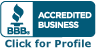

In [27]:
scrapped[0]

In [28]:
len(scrapped)

2000

In [29]:
text_data = [(url, get_data(soup)) for url, soup in scrapped]

In [30]:
text_data[0]

('http://mashable.com/2014/05/28/google-employee-demographics/',
 ("Google's Employee Demographics: Mostly White, Mostly Male",
  0,
  '',
  2,
  1,
  1,
  '\nGoogle released demographic data on its nearly 50,000 employees for the first time Wednesday.\nThe gist: Google employees are predominantly men (70%) and predominantly white (61%).\n[seealso slug="you-are-not-a-princess-ad"]\n"Google is not where we want to be when it comes to diversity," Laszlo Bock, Google\'s senior vice-president of people operations, wrote in a blog post, "And it’s hard to address these kinds of challenges if you’re not prepared to discuss them openly, and with the facts."\nThe gender data shared is global for all Google\'s 50,000 employees, while the ethnicity data is strictly for the company\'s U.S. employees. Overall, 70% of Google employees are male, and 91% of U.S. employees are either white or Asian. Google\'s leadership is even less diverse: 79% of Google\'s leadership is male, while 72% of its leaders

In [31]:
df = pd.DataFrame([{"url": url, "title": features[0], "n_headers": features[1], "channel": features[2], "n_images": features[3], "n_videos": features[4], "n_paragraphs": features[5], "text": features[6]} for url, features in text_data])

In [32]:
df

url  \
0     http://mashable.com/2014/05/28/google-employee...   
1              http://mashable.com/2013/03/05/getgoing/   
2     http://mashable.com/2014/02/05/new-apple-paten...   
3     http://mashable.com/2014/02/22/questions-accep...   
4     http://mashable.com/2013/12/30/marketers-faceb...   
...                                                 ...   
1995  http://mashable.com/2014/05/29/nsa-snowden-ema...   
1996  http://mashable.com/2013/11/13/facebook-haiyan...   
1997  http://mashable.com/2014/04/10/game-of-thrones...   
1998  http://mashable.com/2013/04/06/major-league-ba...   
1999  http://mashable.com/2014/03/12/scrabble-dictio...   

                                                  title  n_headers  \
0     Google's Employee Demographics: Mostly White, ...          0   
1     GetGoing Promises Big Flight Discounts if You ...          0   
2       New Apple Patents Hint at Solar-Powered Devices          0   
3     5 Questions to Ask Yourself Before Accepting a...          0   
4     Marketers Learn to Play by Facebook's Changing...          2   
...                                                 ...        ...   
1995  NSA Releases Snowden's Email, Says He 'Did Not...          0   
1996  'It's Really a Miracle': How a Typhoon Haiyan ...          0   
1997  'Game of Goats' Unseats Joffrey Baaa-ratheon a...          0   
1998   Major League Baseball: The Social Media Rundown           0   
1999  Scrabble Fans: You Can Pick the Game's First N...          0   

            channel  n_images  n_videos  n_paragraphs  \
0                           2         1             1   
1                           2         1             1   
2                           1         1             1   
3                           1         1             1   
4     No Free Lunch         1         1             1   
...             ...       ...       ...           ...   
1995                        1         2             1   
1996                        4         1             1   
1997                        2         1             1   
1998                        2         1             1   
1999                        1         1             1   

                                                   text  
0     \nGoogle released demographic data on its near...  
1     \nThe Launchpad is a series that introduces Ma...  
2     \nApple may be going green in the next few yea...  
3     \nMany job seekers are inclined to jump at the...  
4     \nWhen Sim Partners, a provider of local and s...  
...                                                 ...  
1995  \nDuring his first ever American TV interview,...  
1996  \nOn the morning Typhoon Haiyan tore through t...  
1997  \nKing Joffrey, your reign is over. The people...  
1998  \nSpring is in the air and another Major Leagu...  
1999  \nScrabble has successfully made the jump to t...  

[2000 rows x 8 columns]

In [35]:
df.loc[df["title"] == "", ["url", "title", "n_headers", "n_images","n_videos", "text"]]

Empty DataFrame
Columns: [url, title, n_headers, n_images, n_videos, text]
Index: []

In [36]:
df = df.loc[df["title"] != "", ["url", "title", "n_headers", "n_images","n_videos", "text"]].reset_index(drop=True)

In [37]:
print(df.loc[0, "text"])


Google released demographic data on its nearly 50,000 employees for the first time Wednesday.
The gist: Google employees are predominantly men (70%) and predominantly white (61%).
[seealso slug="you-are-not-a-princess-ad"]
"Google is not where we want to be when it comes to diversity," Laszlo Bock, Google's senior vice-president of people operations, wrote in a blog post, "And it’s hard to address these kinds of challenges if you’re not prepared to discuss them openly, and with the facts."
The gender data shared is global for all Google's 50,000 employees, while the ethnicity data is strictly for the company's U.S. employees. Overall, 70% of Google employees are male, and 91% of U.S. employees are either white or Asian. Google's leadership is even less diverse: 79% of Google's leadership is male, while 72% of its leadership is white.

The data reinforces a gender stereotype common among Silicon Valley tech companies, where men tend to dominate the tech industry; this is evident even w

In [38]:
df

url  \
0     http://mashable.com/2014/05/28/google-employee...   
1              http://mashable.com/2013/03/05/getgoing/   
2     http://mashable.com/2014/02/05/new-apple-paten...   
3     http://mashable.com/2014/02/22/questions-accep...   
4     http://mashable.com/2013/12/30/marketers-faceb...   
...                                                 ...   
1995  http://mashable.com/2014/05/29/nsa-snowden-ema...   
1996  http://mashable.com/2013/11/13/facebook-haiyan...   
1997  http://mashable.com/2014/04/10/game-of-thrones...   
1998  http://mashable.com/2013/04/06/major-league-ba...   
1999  http://mashable.com/2014/03/12/scrabble-dictio...   

                                                  title  n_headers  n_images  \
0     Google's Employee Demographics: Mostly White, ...          0         2   
1     GetGoing Promises Big Flight Discounts if You ...          0         2   
2       New Apple Patents Hint at Solar-Powered Devices          0         1   
3     5 Questions to Ask Yourself Before Accepting a...          0         1   
4     Marketers Learn to Play by Facebook's Changing...          2         1   
...                                                 ...        ...       ...   
1995  NSA Releases Snowden's Email, Says He 'Did Not...          0         1   
1996  'It's Really a Miracle': How a Typhoon Haiyan ...          0         4   
1997  'Game of Goats' Unseats Joffrey Baaa-ratheon a...          0         2   
1998   Major League Baseball: The Social Media Rundown           0         2   
1999  Scrabble Fans: You Can Pick the Game's First N...          0         1   

      n_videos                                               text  
0            1  \nGoogle released demographic data on its near...  
1            1  \nThe Launchpad is a series that introduces Ma...  
2            1  \nApple may be going green in the next few yea...  
3            1  \nMany job seekers are inclined to jump at the...  
4            1  \nWhen Sim Partners, a provider of local and s...  
...        ...                                                ...  
1995         2  \nDuring his first ever American TV interview,...  
1996         1  \nOn the morning Typhoon Haiyan tore through t...  
1997         1  \nKing Joffrey, your reign is over. The people...  
1998         1  \nSpring is in the air and another Major Leagu...  
1999         1  \nScrabble has successfully made the jump to t...  

[2000 rows x 6 columns]

In [42]:
sid = SentimentIntensityAnalyzer()

In [43]:
sid.polarity_scores("Hello world!")

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [40]:
dc_content = [text_features(url, features[-1]) for url, features in text_data]
df_content = pd.concat(dc_content).groupby("url").agg(["mean", "min", "max", "count"])
dc_title = [text_features(url, features[0]) for url, features in text_data]
df_title = pd.concat(dc_title).groupby("url").agg(["mean", "count"])

In [41]:
df_content

neg              \
                                                        mean  min    max   
url                                                                        
http://mashable.com/2013/01/07/lego-taking-robo...  0.002174  0.0  0.050   
http://mashable.com/2013/01/07/monster-katana-b...  0.000000  0.0  0.000   
http://mashable.com/2013/01/07/obama-boombox-is...  0.000000  0.0  0.000   
http://mashable.com/2013/01/07/samsung-mulit-vi...  0.029769  0.0  0.208   
http://mashable.com/2013/01/07/youtube-vs-cable/    0.028261  0.0  0.201   
...                                                      ...  ...    ...   
http://mashable.com/2014/12/26/marshall-woburn-...  0.040816  0.0  0.206   
http://mashable.com/2014/12/26/north-korea-blam...  0.155750  0.0  0.510   
http://mashable.com/2014/12/26/pregnant-woman-o...  0.134576  0.0  0.524   
http://mashable.com/2014/12/27/extremist-leader...  0.152538  0.0  0.364   
http://mashable.com/2014/12/27/seth-rogen-james...  0.030000  0.0  0.270   

                                                               neu         \
                                                   count      mean    min   
url                                                                         
http://mashable.com/2013/01/07/lego-taking-robo...    23  0.918130  0.657   
http://mashable.com/2013/01/07/monster-katana-b...    10  0.957100  0.675   
http://mashable.com/2013/01/07/obama-boombox-is...     7  0.921286  0.615   
http://mashable.com/2013/01/07/samsung-mulit-vi...    13  0.864077  0.615   
http://mashable.com/2013/01/07/youtube-vs-cable/      69  0.869304  0.352   
...                                                  ...       ...    ...   
http://mashable.com/2014/12/26/marshall-woburn-...    38  0.803211  0.200   
http://mashable.com/2014/12/26/north-korea-blam...    16  0.798938  0.490   
http://mashable.com/2014/12/26/pregnant-woman-o...    33  0.797394  0.437   
http://mashable.com/2014/12/27/extremist-leader...    13  0.769615  0.564   
http://mashable.com/2014/12/27/seth-rogen-james...     9  0.844000  0.286   

                                                                    pos       \
                                                    max count      mean  min   
url                                                                            
http://mashable.com/2013/01/07/lego-taking-robo...  1.0    23  0.079696  0.0   
http://mashable.com/2013/01/07/monster-katana-b...  1.0    10  0.042900  0.0   
http://mashable.com/2013/01/07/obama-boombox-is...  1.0     7  0.078714  0.0   
http://mashable.com/2013/01/07/samsung-mulit-vi...  1.0    13  0.106154  0.0   
http://mashable.com/2013/01/07/youtube-vs-cable/    1.0    69  0.102435  0.0   
...                                                 ...   ...       ...  ...   
http://mashable.com/2014/12/26/marshall-woburn-...  1.0    38  0.156026  0.0   
http://mashable.com/2014/12/26/north-korea-blam...  1.0    16  0.045250  0.0   
http://mashable.com/2014/12/26/pregnant-woman-o...  1.0    33  0.068061  0.0   
http://mashable.com/2014/12/27/extremist-leader...  1.0    13  0.077846  0.0   
http://mashable.com/2014/12/27/seth-rogen-james...  1.0     9  0.126000  0.0   

                                                                 compound  \
                                                      max count      mean   
url                                                                         
http://mashable.com/2013/01/07/lego-taking-robo...  0.343    23  0.218539   
http://mashable.com/2013/01/07/monster-katana-b...  0.325    10  0.092180   
http://mashable.com/2013/01/07/obama-boombox-is...  0.385     7  0.143414   
http://mashable.com/2013/01/07/samsung-mulit-vi...  0.385    13  0.115515   
http://mashable.com/2013/01/07/youtube-vs-cable/    0.648    69  0.162475   
...                                                   ...   ...       ...   
http://mashable.com/2014/12/26/marshall-woburn-...  0.800    38  0.260068   
http://mashable.com/20

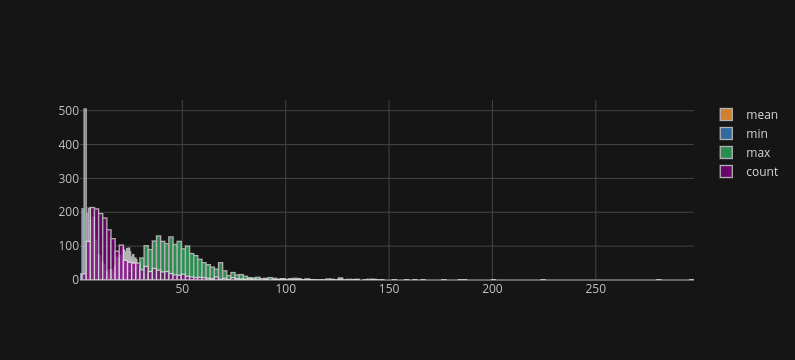

In [44]:
df_content["n_words"].iplot(kind="hist", theme="solar")

In [45]:
df_title = df_title[[(x, y) for x, y in df_title.columns if y != "count"] + [("n_words", "count")]]

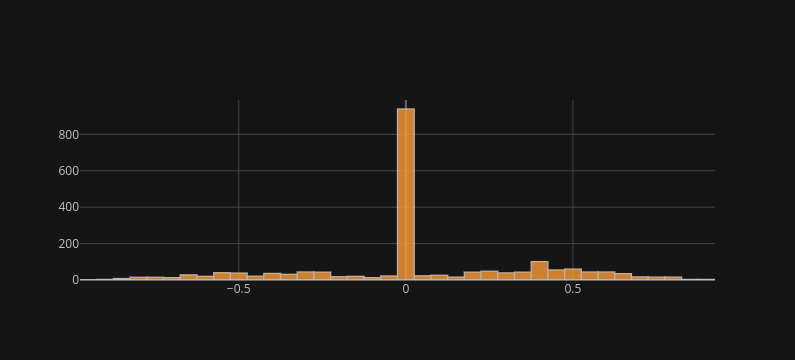

In [47]:
df_title["compound"].iplot(kind="hist", theme="solar")

In [48]:
df_title.columns = ["title_" + "_".join(x) for x in df_title.columns]

In [49]:
df_title = df_title.rename(columns={"title_n_words_count": "title_n_sentences"}).reset_index()

In [50]:
df_title

url  title_neg_mean  \
0     http://mashable.com/2013/01/07/lego-taking-rob...           0.000   
1     http://mashable.com/2013/01/07/monster-katana-...           0.000   
2     http://mashable.com/2013/01/07/obama-boombox-i...           0.000   
3     http://mashable.com/2013/01/07/samsung-mulit-v...           0.000   
4      http://mashable.com/2013/01/07/youtube-vs-cable/           0.328   
...                                                 ...             ...   
1995  http://mashable.com/2014/12/26/marshall-woburn...           0.000   
1996  http://mashable.com/2014/12/26/north-korea-bla...           0.213   
1997  http://mashable.com/2014/12/26/pregnant-woman-...           0.000   
1998  http://mashable.com/2014/12/27/extremist-leade...           0.000   
1999  http://mashable.com/2014/12/27/seth-rogen-jame...           0.000   

      title_neu_mean  title_pos_mean  title_compound_mean  title_n_words_mean  \
0              1.000           0.000               0.0000                 9.0   
1              1.000           0.000               0.0000                 5.0   
2              1.000           0.000               0.0000                 9.0   
3              0.811           0.189               0.2732                11.0   
4              0.672           0.000              -0.5994                10.0   
...              ...             ...                  ...                 ...   
1995           1.000           0.000               0.0000                10.0   
1996           0.787           0.000              -0.4019                14.0   
1997           0.722           0.278               0.4019                 8.0   
1998           1.000           0.000               0.0000                16.0   
1999           1.000           0.000               0.0000                12.0   

      title_n_sentences  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1  
...                 ...  
1995                  1  
1996                  1  
1997                  1  
1998                  1  
1999                  1  

[2000 rows x 7 columns]

In [51]:
df_content = df_content[[(x, y) for x, y in df_content.columns if y != "count"] + [("n_words", "count")]]

In [53]:
df_content.columns = ["content_" + "_".join(x) for x in df_content.columns]

In [54]:
df_content = df_content.rename(columns={"content_n_words_count": "content_n_sentences"}).reset_index()

In [55]:
print("The sum of the list elements is : ", end="")
print(reduce(lambda a, b: a+b, range(10)))

The sum of the list elements is : 45


In [56]:
df_final = reduce(lambda left,right: pd.merge(left,right,on='url'), [df, df_title, df_content])

In [57]:
del df, df_title, df_content, dc_title, dc_content, text_data, scrapped

In [58]:
df_final

url  \
0     http://mashable.com/2014/05/28/google-employee...   
1              http://mashable.com/2013/03/05/getgoing/   
2     http://mashable.com/2014/02/05/new-apple-paten...   
3     http://mashable.com/2014/02/22/questions-accep...   
4     http://mashable.com/2013/12/30/marketers-faceb...   
...                                                 ...   
1995  http://mashable.com/2014/05/29/nsa-snowden-ema...   
1996  http://mashable.com/2013/11/13/facebook-haiyan...   
1997  http://mashable.com/2014/04/10/game-of-thrones...   
1998  http://mashable.com/2013/04/06/major-league-ba...   
1999  http://mashable.com/2014/03/12/scrabble-dictio...   

                                                  title  n_headers  n_images  \
0     Google's Employee Demographics: Mostly White, ...          0         2   
1     GetGoing Promises Big Flight Discounts if You ...          0         2   
2       New Apple Patents Hint at Solar-Powered Devices          0         1   
3     5 Questions to Ask Yourself Before Accepting a...          0         1   
4     Marketers Learn to Play by Facebook's Changing...          2         1   
...                                                 ...        ...       ...   
1995  NSA Releases Snowden's Email, Says He 'Did Not...          0         1   
1996  'It's Really a Miracle': How a Typhoon Haiyan ...          0         4   
1997  'Game of Goats' Unseats Joffrey Baaa-ratheon a...          0         2   
1998   Major League Baseball: The Social Media Rundown           0         2   
1999  Scrabble Fans: You Can Pick the Game's First N...          0         1   

      n_videos                                               text  \
0            1  \nGoogle released demographic data on its near...   
1            1  \nThe Launchpad is a series that introduces Ma...   
2            1  \nApple may be going green in the next few yea...   
3            1  \nMany job seekers are inclined to jump at the...   
4            1  \nWhen Sim Partners, a provider of local and s...   
...        ...                                                ...   
1995         2  \nDuring his first ever American TV interview,...   
1996         1  \nOn the morning Typhoon Haiyan tore through t...   
1997         1  \nKing Joffrey, your reign is over. The people...   
1998         1  \nSpring is in the air and another Major Leagu...   
1999         1  \nScrabble has successfully made the jump to t...   

      title_neg_mean  title_neu_mean  title_pos_mean  title_compound_mean  \
0                0.0           1.000           0.000               0.0000   
1                0.0           0.809           0.191               0.3818   
2                0.0           1.000           0.000               0.0000   
3                0.0           0.698           0.302               0.3818   
4                0.0           0.745           0.255               0.3400   
...              ...             ...             ...                  ...   
1995             0.0           1.000           0.000               0.0000   
1996             0.0           0.800           0.200               0.3612   
1997             0.0           1.000           0.000               0.0000   
1998             0.0           1.000           0.000               0.0000   
1999             0.0           1.000           0.000               0.0000   

      ...  content_pos_mean  content_pos_min  content_pos_max  \
0     ...          0.031923              0.0            0.198   
1     ...          0.101313              0.0            0.455   
2     ...          0.187583              0.0            0.456   
3     ...          0.160688              0.0            0.449   
4     ...          0.080738              0.0            0.385   
...   ...               ...              ...              ...   
1995  ...          0.034324              0.0            0.241   
1996  ...          0.092633              0.0            0.556   
1997  ...          0.140500              0.

## Modelo supervisado

### EDA

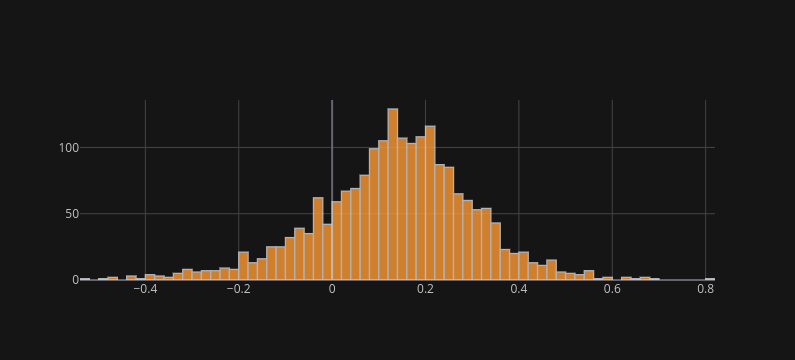

In [59]:
df_final["content_compound_mean"].iplot(kind="hist", theme="solar");

In [60]:
shares

url  timedelta  \
0      http://mashable.com/2013/01/07/amazon-instant-...      731.0   
1      http://mashable.com/2013/01/07/ap-samsung-spon...      731.0   
2      http://mashable.com/2013/01/07/apple-40-billio...      731.0   
3      http://mashable.com/2013/01/07/astronaut-notre...      731.0   
4       http://mashable.com/2013/01/07/att-u-verse-apps/      731.0   
...                                                  ...        ...   
39639  http://mashable.com/2014/12/27/samsung-app-aut...        8.0   
39640  http://mashable.com/2014/12/27/seth-rogen-jame...        8.0   
39641  http://mashable.com/2014/12/27/son-pays-off-mo...        8.0   
39642     http://mashable.com/2014/12/27/ukraine-blasts/        8.0   
39643  http://mashable.com/2014/12/27/youtube-channel...        8.0   

       n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
0                12.0             219.0         0.663594               1.0   
1                 9.0             255.0         0.604743               1.0   
2                 9.0             211.0         0.575130               1.0   
3                 9.0             531.0         0.503788               1.0   
4                13.0            1072.0         0.415646               1.0   
...               ...               ...              ...               ...   
39639            11.0             346.0         0.529052               1.0   
39640            12.0             328.0         0.696296               1.0   
39641            10.0             442.0         0.516355               1.0   
39642             6.0             682.0         0.539493               1.0   
39643            10.0             157.0         0.701987               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_self_hrefs  num_imgs  ...  \
0                      0.815385        4.0             2.0       1.0  ...   
1                      0.791946        3.0             1.0       1.0  ...   
2                      0.663866        3.0             1.0       1.0  ...   
3                      0.665635        9.0             0.0       1.0  ...   
4                      0.540890       19.0            19.0      20.0  ...   
...                         ...        ...             ...       ...  ...   
39639                  0.684783        9.0             7.0       1.0  ...   
39640                  0.885057        9.0             7.0       3.0  ...   
39641                  0.644128       24.0             1.0      12.0  ...   
39642                  0.692661       10.0             1.0       1.0  ...   
39643                  0.846154        1.0             1.0       0.0  ...   

       min_positive_polarity  max_positive_polarity  avg_negative_polarity  \
0                   0.100000                   0.70              -0.350000   
1                   0.033333                   0.70              -0.118750   
2                   0.100000                   1.00              -0.466667   
3                   0.136364                   0.80              -0.369697   
4                   0.033333                   1.00              -0.220192   
...                      ...                    ...                    ...   
39639               0.100000                   0.75              -0.260000   
39640               0.136364                   0.70              -0.211111   
39641               0.136364                   0.50              -0.356439   
39642               0.062500                   0.50              -0.205246   
39643               0.100000                   0.50              -0.200000   

       min_negative_polarity  max_negative_polarity  title_subjectivity  \
0                     -0.600              -0.200000            0.500000   
1                     -0.125              -0.100000            0.000000   
2                     -0.800              -0.133333            0.000000   
3                     -0.600              -0.166667            0.000000   
4                     -0.5

In [61]:
shares = shares[["url", "shares"]]

In [62]:
titles = " ".join(df_final["title"].str.lower())

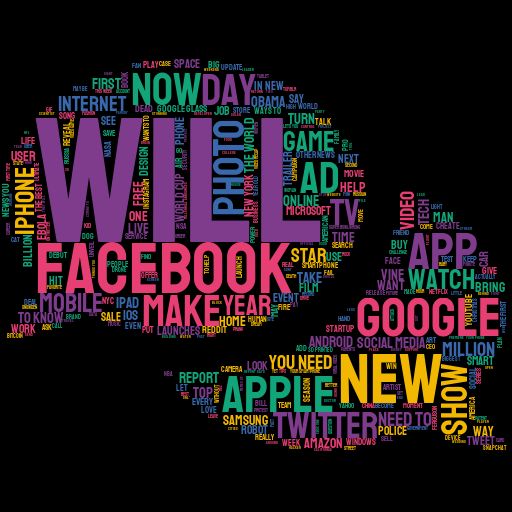

In [63]:
get_wordcloud(titles)

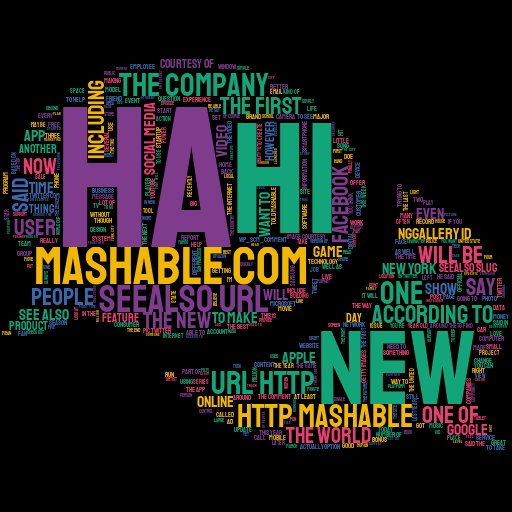

In [64]:
get_wordcloud(" ".join(df_final["text"]))

In [65]:
text = df_final.loc[2, "text"]

In [68]:
text

'\nApple may be going green in the next few years, based on the latest patents given to the company, which reveal solar cells may soon be in all of Apple’s devices.\nApple appears to be creating a new device that can let natural light in and absorb the energy via solar cells in the devices. The key component in the patent is Smart Glass, or electrochromic glass. Acting like sunglasses, the glass can fluctuate its translucency to filter in light.\n[seealso url="http://mashable.com/2014/01/28/apple-iphone-growth-rate/"]\nThe idea is to have a layer of photovoltaic cells – cells found in solar panels that absorb energy – located behind the LCD screen on the back of the device to work with the Smart Glass. Since the Smart Glass can sense when natural light is present and filter more light in, the solar cells would absorb more energy when needed and available. This gives new meaning to the term “smart device.”\nApple was also granted a patent for rear-facing touch controls, a design made wi

In [67]:
re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.#&+])+', text)

['http://mashable.com/2014/01/28/apple-iphone-growth-rate/']

In [69]:
df_final["urls"] = df_final["text"].str.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.#&+])+')

In [70]:
df_final["n_urls"] = df_final["urls"].str.len()

In [72]:
string = df_final.loc[1076, "text"]
ls_urls = df_final.loc[1076, "urls"]

In [73]:
string

'\nThe road to Vine fame is paved with stumbles, tumbles and epic six-second fails.\nThe Twitter account @FailVine collects the most awkward and painful moments shared on Vine. If your Twitter feed needs more poolside slips and coning retaliation, look no further. The fail aggregators already have a 800,000 follower-strong presence on Vine.\n[seealso url="http://mashable.com/2013/07/31/vine-colors-in-motion/"]\nScroll down for 11 of the disasters and follow the account for more Vine fails.\n"I just want to be sexy like Cameron Diaz #fail #fantacyVSreality #carwash" https://t.co/4wMnidipEv\n— FailVine (@FailVine) August 9, 2013\n\xa0\ndid i seriously just hit my head.... https://t.co/6SXUafC82l\n— FailVine (@FailVine) August 6, 2013\n\xa0\nNope not today. https://t.co/2hq9Y2G5Ix\n— FailVine (@FailVine) August 3, 2013\n\xa0\nOops https://t.co/9Yy48Zhv8M\n— FailVine (@FailVine) August 2, 2013\n\xa0\n"#Parkour #fail Just put a hole in my favorite jeans " https://t.co/I87Z5OETvD\n— FailVine

In [74]:
ls_urls

['http://mashable.com/2013/07/31/vine-colors-in-motion/',
 'https://t.co/4wMnidipEv',
 'https://t.co/6SXUafC82l',
 'https://t.co/2hq9Y2G5Ix',
 'https://t.co/9Yy48Zhv8M',
 'https://t.co/I87Z5OETvD',
 'https://t.co/i2tsUSeEZw',
 'https://t.co/mWTsPUhJG9',
 'https://t.co/QIB3KMu2iR',
 'https://t.co/eRkcSexiDd',
 'https://t.co/mwXDVAiYgr',
 'https://t.co/o0955BouzI']

In [75]:
reduce(lambda string, url: string.replace(url, ""), ls_urls, string)

'\nThe road to Vine fame is paved with stumbles, tumbles and epic six-second fails.\nThe Twitter account @FailVine collects the most awkward and painful moments shared on Vine. If your Twitter feed needs more poolside slips and coning retaliation, look no further. The fail aggregators already have a 800,000 follower-strong presence on Vine.\n[seealso url=""]\nScroll down for 11 of the disasters and follow the account for more Vine fails.\n"I just want to be sexy like Cameron Diaz #fail #fantacyVSreality #carwash" \n— FailVine (@FailVine) August 9, 2013\n\xa0\ndid i seriously just hit my head.... \n— FailVine (@FailVine) August 6, 2013\n\xa0\nNope not today. \n— FailVine (@FailVine) August 3, 2013\n\xa0\nOops \n— FailVine (@FailVine) August 2, 2013\n\xa0\n"#Parkour #fail Just put a hole in my favorite jeans " \n— FailVine (@FailVine) August 9, 2013\n\xa0\nGet back !!!!!!!! — FailVine (@FailVine) August 9, 2013\n\nSometimes you just don\'t care ! — FailVine (@FailVine) August 8, 2013\n\n

In [76]:
df_final["text_cleaned"] = df_final.apply(lambda row: reduce(lambda string, url: string.replace(url, ""), row["urls"], row["text"]), axis = 1)

In [78]:
df_final["len_title"] = df_final["title"].str.len()
df_final["n_words_title"] = df_final["title"].str.split(" ").str.len()
df_final["avg_len_words_title"] = df_final["title"].str.split(" ").map(lambda x:np.mean([x for x in map(len, x)]))
df_final["len_content"] = df_final["text"].str.len()
df_final["n_words_content"] = df_final["text"].str.split(" ").str.len()
df_final["avg_len_words_content"] = df_final["text"].str.split(" ").map(lambda x:np.mean([x for x in map(len, x)]))

In [79]:
stop_words = stopwords.words("english") + ["url", "seealso", "mashable", "http", "ha", "hi", "will", "new", "one"]

In [80]:
stop_words = [clean_text(word) for word in stop_words]

In [81]:
df_final["text_cleaned"] = df_final["text_cleaned"].map(clean_text).map(lambda text: [word for word in text.split() if word not in stop_words]).str.join(" ")

In [82]:
df_final["text_cleaned"]

0       google released demographic data nearly employ...
1       launchpad series introduces readers compelling...
2       apple may going green next years based latest ...
3       many job seekers inclined jump first job offer...
4       sim partners provider local social marketing t...
                              ...                        
1995    first ever american tv interview edward snowde...
1996    morning typhoon haiyan tore philippines yearol...
1997    king joffrey reign people westeros demand voic...
1998    spring air another major league baseball seaso...
1999    scrabble successfully made jump digital age st...
Name: text_cleaned, Length: 2000, dtype: object

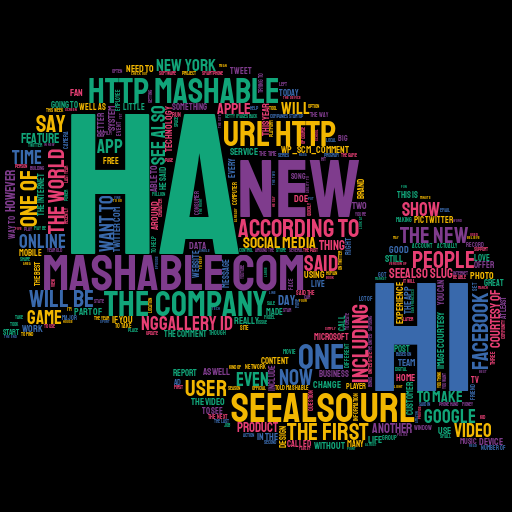

In [83]:
get_wordcloud(" ".join(df_final["text"]))

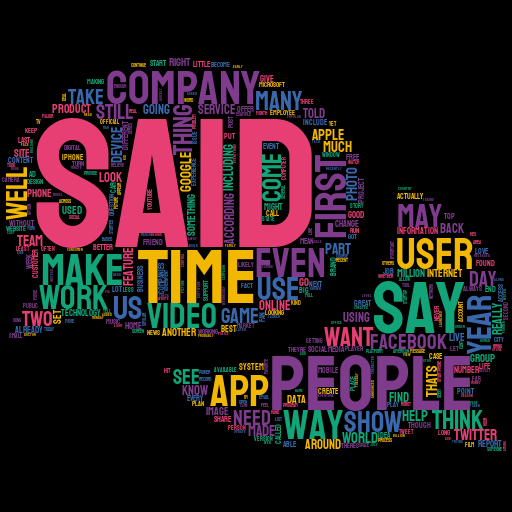

In [84]:
get_wordcloud(" ".join(df_final["text_cleaned"]))

In [85]:
df_final["title_cleaned"] = df_final["title"].str.replace("\n", " ").map(clean_text).map(lambda text: [word for word in text.split() if word not in stop_words]).str.join(" ")

In [86]:
df_final["title_cleaned"]

0       googles employee demographics mostly white mos...
1       getgoing promises big flight discounts let pic...
2                 apple patents hint solarpowered devices
3                             questions ask accepting job
4           marketers learn play facebooks changing rules
                              ...                        
1995      nsa releases snowdens email says raise concerns
1996    really miracle typhoon haiyan survivor found w...
1997          game goats unseats joffrey baaaratheon king
1998           major league baseball social media rundown
1999            scrabble fans pick games first word years
Name: title_cleaned, Length: 2000, dtype: object

In [87]:
df_final = df_final.merge(shares, on ="url")

In [88]:
df_final["shares"].describe([0.95, 0.99])

count    2000.000000
mean       16.770556
std        46.399334
min         0.061625
50%         5.218337
95%        60.515888
99%       189.793110
max       912.703102
Name: shares, dtype: float64

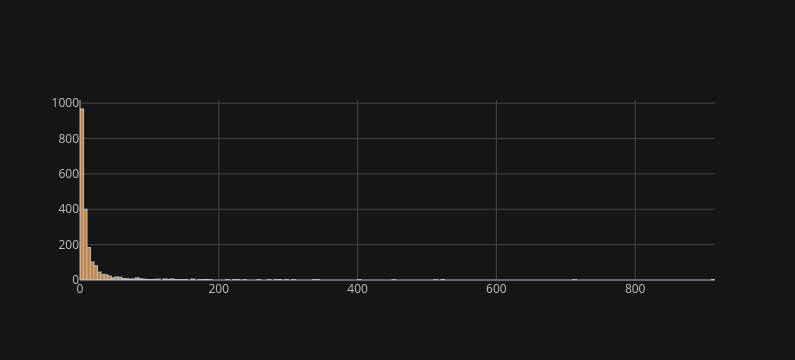

In [89]:
df_final["shares"].iplot(kind="hist", theme="solar");

In [90]:
df_final = df_final[df_final["shares"] <= 200].reset_index(drop = True)

In [91]:
df_final.shape

(1980, 39)

### Modelado

#### Separación de sets

In [92]:
df_final

url  \
0     http://mashable.com/2014/05/28/google-employee...   
1              http://mashable.com/2013/03/05/getgoing/   
2     http://mashable.com/2014/02/05/new-apple-paten...   
3     http://mashable.com/2014/02/22/questions-accep...   
4     http://mashable.com/2013/12/30/marketers-faceb...   
...                                                 ...   
1975  http://mashable.com/2014/05/29/nsa-snowden-ema...   
1976  http://mashable.com/2013/11/13/facebook-haiyan...   
1977  http://mashable.com/2014/04/10/game-of-thrones...   
1978  http://mashable.com/2013/04/06/major-league-ba...   
1979  http://mashable.com/2014/03/12/scrabble-dictio...   

                                                  title  n_headers  n_images  \
0     Google's Employee Demographics: Mostly White, ...          0         2   
1     GetGoing Promises Big Flight Discounts if You ...          0         2   
2       New Apple Patents Hint at Solar-Powered Devices          0         1   
3     5 Questions to Ask Yourself Before Accepting a...          0         1   
4     Marketers Learn to Play by Facebook's Changing...          2         1   
...                                                 ...        ...       ...   
1975  NSA Releases Snowden's Email, Says He 'Did Not...          0         1   
1976  'It's Really a Miracle': How a Typhoon Haiyan ...          0         4   
1977  'Game of Goats' Unseats Joffrey Baaa-ratheon a...          0         2   
1978   Major League Baseball: The Social Media Rundown           0         2   
1979  Scrabble Fans: You Can Pick the Game's First N...          0         1   

      n_videos                                               text  \
0            1  \nGoogle released demographic data on its near...   
1            1  \nThe Launchpad is a series that introduces Ma...   
2            1  \nApple may be going green in the next few yea...   
3            1  \nMany job seekers are inclined to jump at the...   
4            1  \nWhen Sim Partners, a provider of local and s...   
...        ...                                                ...   
1975         2  \nDuring his first ever American TV interview,...   
1976         1  \nOn the morning Typhoon Haiyan tore through t...   
1977         1  \nKing Joffrey, your reign is over. The people...   
1978         1  \nSpring is in the air and another Major Leagu...   
1979         1  \nScrabble has successfully made the jump to t...   

      title_neg_mean  title_neu_mean  title_pos_mean  title_compound_mean  \
0                0.0           1.000           0.000               0.0000   
1                0.0           0.809           0.191               0.3818   
2                0.0           1.000           0.000               0.0000   
3                0.0           0.698           0.302               0.3818   
4                0.0           0.745           0.255               0.3400   
...              ...             ...             ...                  ...   
1975             0.0           1.000           0.000               0.0000   
1976             0.0           0.800           0.200               0.3612   
1977             0.0           1.000           0.000               0.0000   
1978             0.0           1.000           0.000               0.0000   
1979             0.0           1.000           0.000               0.0000   

      ...  n_urls                                       text_cleaned  \
0     ...       0  google released demographic data nearly employ...   
1     ...       0  launchpad series introduces readers compelling...   
2     ...       1  apple may going green next years based latest ...   
3     ...       0  many job seekers inclined jump first job offer...   
4     ...       0  sim partners provider local social marketing t...   
...   ...     ...                                                ...   
1975  ...       1  first ever american tv interview edward snowde...   
1976  ...       1  morning typhoon haiyan tore phili

##### Input texto (titulo)

In [93]:
X_title = df_final["title_cleaned"]

In [94]:
X_title.str.split().str.len().max()

11

In [95]:
title_max_words = 5000
title_max_sequence_length = 11

In [96]:
X_title, tokenizer_title = vectorize_text(X_title, title_max_words, title_max_sequence_length)

Found 5342 unique tokens.


##### Input texto (contenido)

In [97]:
X_content = df_final["text_cleaned"]

In [98]:
X_content.str.split().str.len().max()

3380

In [99]:
content_max_words = 10000
content_max_sequence_length = 250

In [100]:
X_content, tokenizer_content = vectorize_text(X_content, content_max_words, content_max_sequence_length)

Found 58215 unique tokens.


##### Input numérico

In [101]:
ls_features = ["n_images",
               "n_videos",
               "title_compound_mean",
               "content_compound_mean",
               "content_n_words_mean",
               "n_urls",
               'len_title',
               'n_words_title',
               'avg_len_words_title',
               'len_content',
               'n_words_content',
               'avg_len_words_content']

In [102]:
X_features = df_final[ls_features]

In [103]:
pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())])

In [104]:
X_features = pipe.fit_transform(X_features)

In [105]:
X_features

array([[0.025     , 0.        , 0.50727492, ..., 0.05073878, 0.05127186,
        0.242931  ],
       [0.025     , 0.        , 0.71611421, ..., 0.10184927, 0.10790938,
        0.16154051],
       [0.        , 0.        , 0.50727492, ..., 0.0446365 , 0.0472973 ,
        0.16315247],
       ...,
       [0.025     , 0.        , 0.50727492, ..., 0.0243162 , 0.02344992,
        0.315849  ],
       [0.025     , 0.        , 0.50727492, ..., 0.03109996, 0.03298887,
        0.16274943],
       [0.        , 0.        , 0.50727492, ..., 0.059505  , 0.06081081,
        0.2238468 ]])

In [106]:
X_title.shape, X_content.shape, X_features.shape

((1980, 11), (1980, 250), (1980, 12))

In [107]:
X_title

array([[   0,    0,    0, ...,  179, 1092, 1930],
       [   0,    0,    0, ...,  504,  743, 1933],
       [   0,    0,    0, ..., 1934, 1094,  505],
       ...,
       [   0,    0,    0, ...,   17, 1885,  245],
       [   0,    0,    0, ...,  911,   10,   11],
       [   0,    0,    0, ...,    6, 1046,   52]], dtype=int32)

In [108]:
X_content

array([[   0,    0,    0, ...,   70, 1224, 4753],
       [2922, 1575, 1418, ...,   98,   75, 6414],
       [   0,    0,    0, ...,   34,   77,  120],
       ...,
       [   0,    0,    0, ...,  876, 1654, 1388],
       [   0,    0,    0, ..., 7295,  188,   81],
       [   0,    0,    0, ..., 2627, 2509,  120]], dtype=int32)

In [109]:
X_features

array([[0.025     , 0.        , 0.50727492, ..., 0.05073878, 0.05127186,
        0.242931  ],
       [0.025     , 0.        , 0.71611421, ..., 0.10184927, 0.10790938,
        0.16154051],
       [0.        , 0.        , 0.50727492, ..., 0.0446365 , 0.0472973 ,
        0.16315247],
       ...,
       [0.025     , 0.        , 0.50727492, ..., 0.0243162 , 0.02344992,
        0.315849  ],
       [0.025     , 0.        , 0.50727492, ..., 0.03109996, 0.03298887,
        0.16274943],
       [0.        , 0.        , 0.50727492, ..., 0.059505  , 0.06081081,
        0.2238468 ]])

##### Variable objetivo

In [110]:
y = df_final[["shares"]]

In [111]:
sc = MinMaxScaler()

In [112]:
y = sc.fit_transform(y).ravel()

### Arquitectura del modelo (functional API)

#### Capas de entrada

In [114]:
title_input = Input(shape=(None,), name="title")
content_input = Input(shape=(None,), name="content")
features_input = Input(shape=(X_features.shape[1],), name="features")

#### Capas de embedding

In [115]:
title_embedding = Embedding(title_max_words, 64)(title_input)
content_embedding = Embedding(content_max_words, 128)(content_input)

#### Capas GRU

In [116]:
title_features = GRU(32)(title_embedding)
content_features = GRU(64)(content_embedding)

#### Capa densa para variables numéricas

In [117]:
features_network = Dense(64, activation="tanh")(features_input)

#### Capa de concatenación

In [118]:
x = concatenate([title_features, content_features, features_network])

#### Capa densa

In [119]:
x = Dense(100, activation="sigmoid")(x)

#### Capa de salida

In [120]:
pred = Dense(1, activation="linear")(x)

#### Métricas de performance

In [121]:
kmetrics = [
    metrics.RootMeanSquaredError(name='rms'),
    metrics.MeanAbsoluteError(name='mae'),
    metrics.MeanAbsolutePercentageError(name="pema")
]   

#### Creación de modelo

In [122]:
model = Model(inputs=[title_input, content_input, features_input], outputs=pred)

In [123]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
content (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     320000      title[0][0]                      
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    1280000     content[0][0]                    
______________________________________________________________________________________________

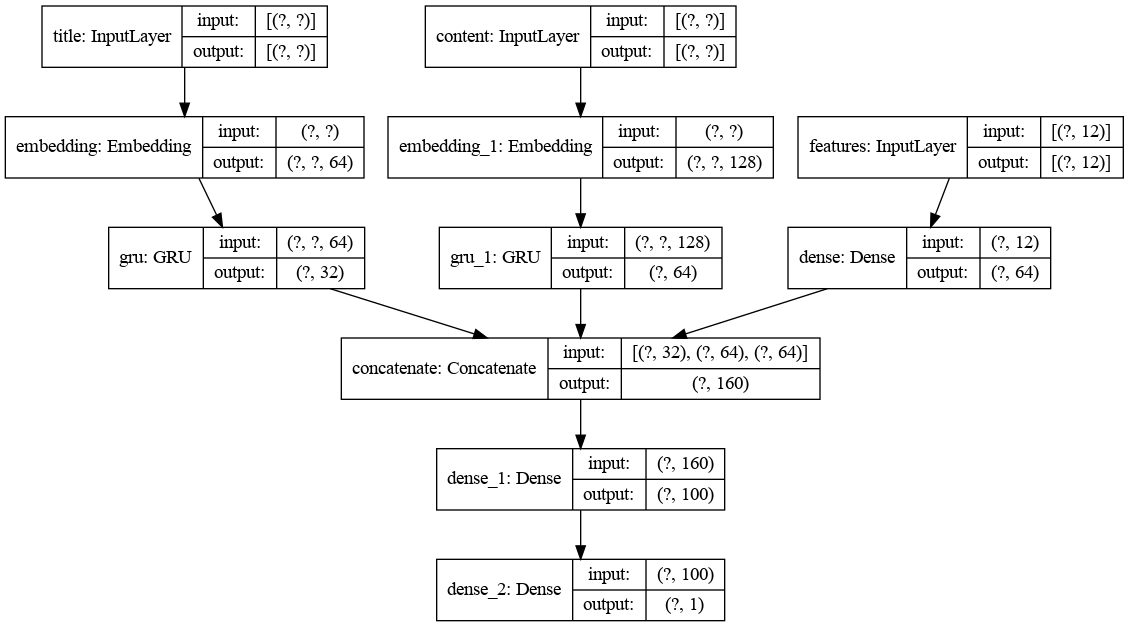

In [124]:
plot_model(model, "multi_input_model.png", show_shapes=True)

#### Configuración de modelo

In [125]:
model.compile(optimizer=Adam(), loss=["mae"], metrics=kmetrics)

#### Callbacks

In [126]:
early_stopping = EarlyStopping(monitor='val_mae', patience=15, min_delta=0.0001)

In [127]:
checkpoint = ModelCheckpoint('models/onp/model_{val_mae:.3f}.h5',
                             save_best_only=True,
                             save_weights_only=False,
                             monitor='val_mae')

In [128]:
tensorboard = TensorBoard(log_dir="./logs")

#### Train-test split

In [129]:
Xtitle_train, Xtitle_test, Xcontent_train, Xcontent_test, Xfeatures_train, Xfeatures_test, y_train, y_test = train_test_split(X_title, X_content, X_features, y, test_size=0.3, shuffle=True)

#### Entrenamiento

In [130]:
history = model.fit(x={"title": Xtitle_train, "content": Xcontent_train, "features": Xfeatures_train}, 
                    y=y_train, 
                    epochs=100,
                    validation_data=([Xtitle_test, Xcontent_test, Xfeatures_test], y_test),
                    callbacks=[early_stopping, checkpoint, tensorboard])

Epoch 1/100
44/44 [==============================] - 10s 229ms/step - loss: 0.1223 - rms: 0.1917 - mae: 0.1223 - pema: 19532.1738 - val_loss: 0.0622 - val_rms: 0.1247 - val_mae: 0.0622 - val_pema: 250.4225
Epoch 2/100
44/44 [==============================] - 7s 155ms/step - loss: 0.0571 - rms: 0.1180 - mae: 0.0571 - pema: 18801.9199 - val_loss: 0.0621 - val_rms: 0.1207 - val_mae: 0.0621 - val_pema: 258.4286
Epoch 3/100
44/44 [==============================] - 9s 197ms/step - loss: 0.0474 - rms: 0.1090 - mae: 0.0474 - pema: 20772.6055 - val_loss: 0.0555 - val_rms: 0.1228 - val_mae: 0.0555 - val_pema: 158.9389
Epoch 4/100
44/44 [==============================] - 8s 177ms/step - loss: 0.0423 - rms: 0.1018 - mae: 0.0423 - pema: 26197.1777 - val_loss: 0.0594 - val_rms: 0.1200 - val_mae: 0.0594 - val_pema: 231.3052
Epoch 5/100
44/44 [==============================] - 7s 149ms/step - loss: 0.0363 - rms: 0.0939 - mae: 0.0363 - pema: 1530.1759 - val_loss: 0.0555 - val_rms: 0.1233 - val_mae: 0.0

#### Análisis de resultados

In [131]:
results = pd.DataFrame(data = zip(history.history["loss"], history.history["val_loss"], history.history["pema"], history.history["val_pema"]), columns=["loss", "val_loss", "pema", "val_pema"])

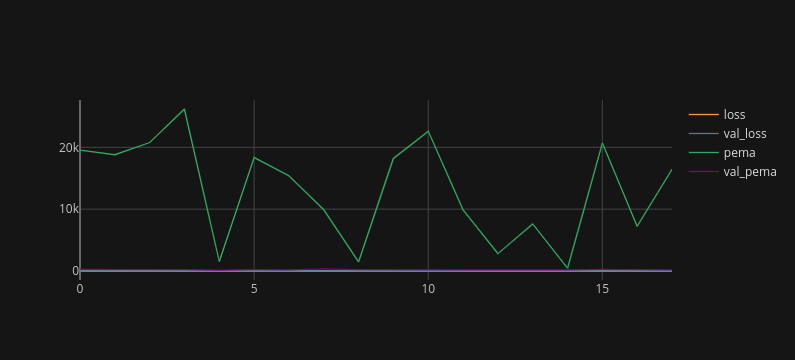

In [132]:
results.iplot(theme="solar")

#### Predicción

In [133]:
model.predict([Xtitle_test, Xcontent_test, Xfeatures_test])

array([[ 9.81249586e-02],
       [ 1.17966291e-02],
       [-9.19761695e-03],
       [ 4.12342921e-02],
       [ 4.92020026e-02],
       [ 6.92561641e-02],
       [ 4.56811562e-02],
       [ 2.60672532e-03],
       [ 7.35783353e-02],
       [ 4.90258709e-02],
       [ 5.73912822e-03],
       [-1.78631581e-03],
       [ 4.84722033e-02],
       [ 1.00078918e-01],
       [ 7.62279406e-02],
       [ 5.54848686e-02],
       [ 4.25054803e-02],
       [ 7.32946172e-02],
       [ 4.72904816e-02],
       [ 3.43092456e-02],
       [ 4.71836701e-02],
       [ 2.23566052e-02],
       [ 7.13016167e-02],
       [ 1.69823524e-02],
       [-3.44360247e-04],
       [ 4.10952941e-02],
       [ 1.80763956e-02],
       [ 4.11549769e-03],
       [ 7.89167061e-02],
       [ 8.34385529e-02],
       [ 4.01964560e-02],
       [ 2.68764254e-02],
       [ 5.16429916e-02],
       [ 8.54564086e-02],
       [ 2.09660884e-02],
       [ 5.79907075e-02],
       [ 2.90573593e-02],
       [ 5.62984124e-02],
       [ 4.7

In [134]:
loss, *metrics = model.evaluate([Xtitle_test, Xcontent_test, Xfeatures_test], y_test)

19/19 [==============================] - 0s 26ms/step - loss: 0.0581 - rms: 0.1224 - mae: 0.0581 - pema: 170.7887


In [135]:
loss

0.05808679386973381

In [136]:
metrics

[0.12243518233299255, 0.05808679386973381, 170.7887420654297]

In [137]:
y_true = sc.inverse_transform(np.expand_dims(y_test, axis=1))

In [138]:
y_pred = sc.inverse_transform(model.predict([Xtitle_test, Xcontent_test, Xfeatures_test]))

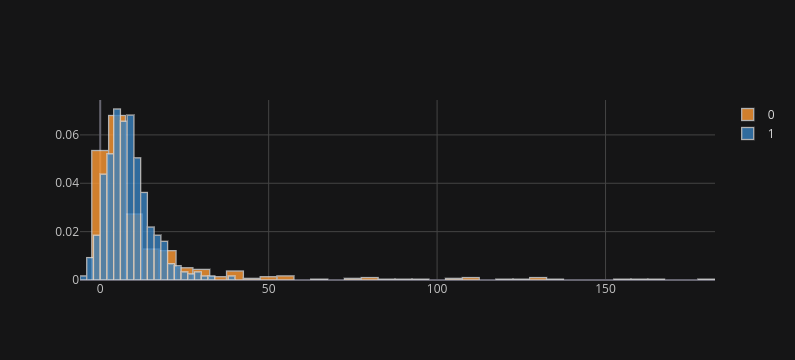

In [139]:
pd.DataFrame(zip(y_true.ravel(), y_pred.ravel())).iplot(kind="histogram", histnorm="probability density", theme="solar")

In [140]:
r2_score(y_pred=y_pred, y_true=y_true)

0.028170043561956182

## Modelado no supervisado

#### Ingeniería de datos "profunda"

In [141]:
X_input = [X_title, X_content, X_features]

In [142]:
model_transformer = Model(inputs=[title_input, content_input, features_input], outputs=x)

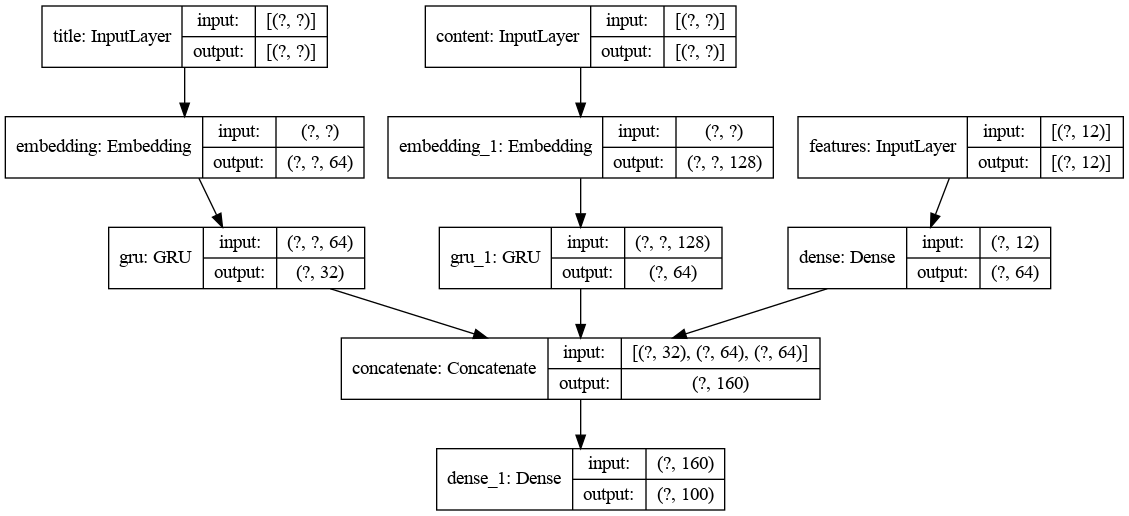

In [143]:
plot_model(model_transformer, "model_transformer.png", show_shapes=True)

In [144]:
Xt = model_transformer.predict(X_input)

In [146]:
Xt.shape

(1980, 100)

In [147]:
sc_x = MinMaxScaler()
Xs = pd.DataFrame(data=sc_x.fit_transform(Xt), columns=[f"x_{i}" for i in range(Xt.shape[1])])

In [148]:
Xs

x_0       x_1       x_2       x_3       x_4       x_5       x_6  \
0     0.236595  0.317533  0.859715  0.796478  0.278488  0.576356  0.353221   
1     0.434321  0.382007  0.788968  0.822052  0.560908  0.551909  0.550235   
2     0.317336  0.278235  0.807675  0.800585  0.244331  0.752095  0.461968   
3     0.378593  0.279120  0.729538  0.744668  0.529558  0.698615  0.338493   
4     0.480165  0.288669  0.792675  0.679263  0.533264  0.652023  0.579629   
...        ...       ...       ...       ...       ...       ...       ...   
1975  0.292315  0.428816  0.784652  0.759149  0.516593  0.545098  0.319028   
1976  0.375973  0.554736  0.806237  0.872693  0.525028  0.549649  0.335041   
1977  0.367935  0.371963  0.808320  0.786495  0.413388  0.612843  0.550489   
1978  0.350942  0.279531  0.799221  0.836489  0.320021  0.725079  0.375440   
1979  0.478481  0.416119  0.700697  0.753715  0.499058  0.592293  0.543589   

           x_7       x_8       x_9  ...      x_90      x_91      x_92  \
0     0.407653  0.399668  0.839458  ...  0.507989  0.301568  0.153074   
1     0.377108  0.423606  0.859137  ...  0.450862  0.439416  0.264097   
2     0.454051  0.400698  0.857670  ...  0.388737  0.555237  0.213956   
3     0.382114  0.397765  0.835224  ...  0.325814  0.631463  0.293767   
4     0.491247  0.307138  0.804774  ...  0.315344  0.653265  0.249574   
...        ...       ...       ...  ...       ...       ...       ...   
1975  0.319437  0.427883  0.863689  ...  0.551647  0.316101  0.199711   
1976  0.249202  0.493368  0.915252  ...  0.523826  0.381335  0.237945   
1977  0.456219  0.378583  0.827319  ...  0.418028  0.416486  0.193668   
1978  0.308591  0.352087  0.878322  ...  0.367695  0.455260  0.228522   
1979  0.337784  0.490233  0.800059  ...  0.455672  0.461138  0.244157   

          x_93      x_94      x_95      x_96      x_97      x_98      x_99  
0     0.698931  0.084172  0.242214  0.442134  0.607642  0.279244  0.222329  
1     0.576765  0.261924  0.211311  0.341026  0.686548  0.150511  0.253939  
2     0.740794  0.193052  0.189480  0.461419  0.545425  0.190354  0.229373  
3     0.766032  0.333535  0.218275  0.492659  0.500641  0.134036  0.291042  
4     0.653438  0.285875  0.279200  0.599745  0.659661  0.193635  0.224817  
...        ...       ...       ...       ...       ...       ...       ...  
1975  0.503437  0.300967  0.207062  0.411024  0.717064  0.324313  0.198227  
1976  0.510556  0.330853  0.154036  0.308077  0.720347  0.192860  0.176818  
1977  0.609337  0.214087  0.268249  0.446472  0.671039  0.293693  0.293812  
1978  0.659146  0.276772  0.181691  0.431504  0.570565  0.214357  0.269417  
1979  0.483969  0.299883  0.165144  0.324018  0.714654  0.295709  0.205443  

[1980 rows x 100 columns]

### Visualización

In [151]:
pca = PCA(n_components=0.9)

In [152]:
pca.fit(Xs)

PCA(n_components=0.9)

In [153]:
pca.n_components_

10

In [154]:
pca.explained_variance_ratio_.cumsum()

array([0.3227862 , 0.48469752, 0.6172506 , 0.68584186, 0.7463554 ,
       0.79561025, 0.83511806, 0.8710502 , 0.89390975, 0.90843266],
      dtype=float32)

In [155]:
Xp = pd.DataFrame(columns=[f"p{i+1}" for i in range(pca.n_components_)], data=pca.transform(Xs))

In [156]:
Xp

p1        p2        p3        p4        p5        p6        p7  \
0    -0.413150  0.216467  0.203704  0.372441  0.035764 -0.409159  0.224098   
1    -0.096850  0.419221 -0.685331  0.082775  0.130878 -0.148380 -0.158588   
2    -0.430413 -0.437636  0.084787  0.114025  0.100793 -0.187420  0.262726   
3    -0.035491 -0.468177 -0.426246 -0.151858  0.100313 -0.148013  0.149816   
4     0.276267 -0.289620 -0.154392  0.031529 -0.161936 -0.218324 -0.372524   
...        ...       ...       ...       ...       ...       ...       ...   
1975 -0.077256  0.551650 -0.044402 -0.118143 -0.130845 -0.113369 -0.144790   
1976 -0.153748  0.749631 -0.762684 -0.264469  0.035250 -0.184800 -0.048373   
1977 -0.014005 -0.113024  0.204748  0.103482 -0.200250  0.017694 -0.165482   
1978 -0.465976 -0.263460 -0.007513 -0.092630  0.091223 -0.066087  0.110886   
1979  0.007589  0.358358 -0.304927 -0.209697  0.279386  0.271948 -0.102830   

            p8        p9       p10  
0     0.196554 -0.072321  0.045163  
1    -0.158626 -0.131264  0.016814  
2    -0.215463  0.024394  0.047051  
3    -0.094807  0.006337  0.209678  
4    -0.297574  0.098533  0.034807  
...        ...       ...       ...  
1975  0.214539  0.089810  0.007073  
1976  0.096029  0.024224 -0.102997  
1977 -0.216812 -0.136053 -0.058155  
1978 -0.037270 -0.103105 -0.079304  
1979 -0.150183 -0.057668 -0.055559  

[1980 rows x 10 columns]

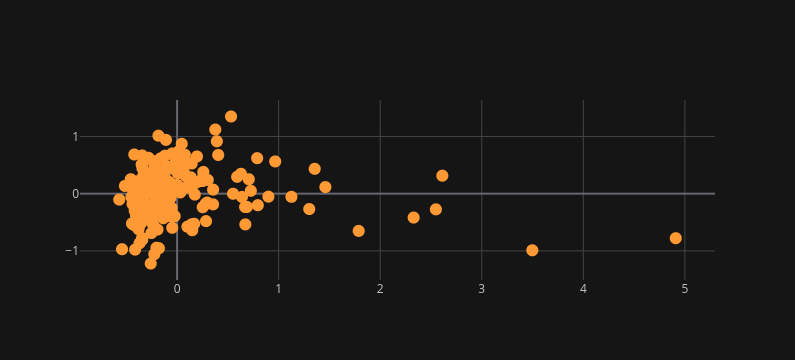

In [158]:
Xp.sample(frac=0.1).iplot(kind="scatter", x="p1", y="p2", mode="markers", theme="solar")

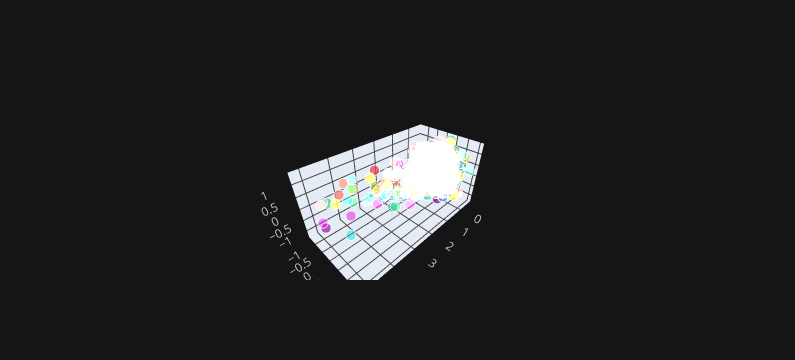

In [159]:
Xp.iplot(kind="scatter3d", x="p1", y="p2", z="p3", mode="markers", theme="solar")

### K-Means

In [160]:
cluster = KMeans(n_clusters=3, random_state=777)

In [161]:
df_final["cl"] = Xs["cl"] = Xp["cl"] = [str(x) for x in cluster.fit_predict(Xs)]

### Perfilamiento

/home/oscar/VirtualEnvs/Python 3/lib/python3.7/site-packages/cufflinks/plotlytools.py:807: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

/home/oscar/VirtualEnvs/Python 3/lib/python3.7/site-packages/cufflinks/plotlytools.py:810: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



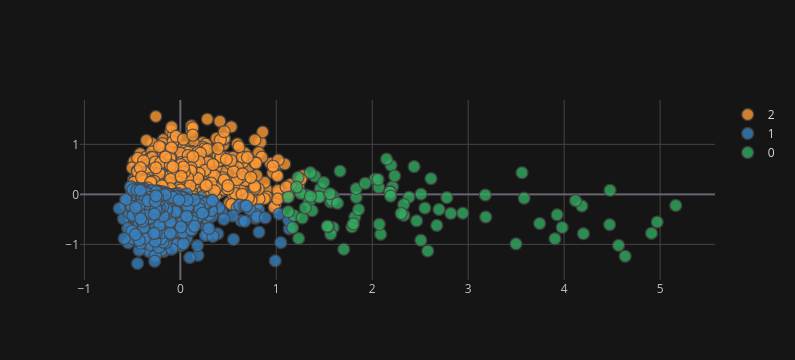

In [162]:
Xp.join(df_final[["title"]]).iplot(kind="scatter", x="p1", y="p2", mode="markers", categories="cl", text="title", theme="solar")

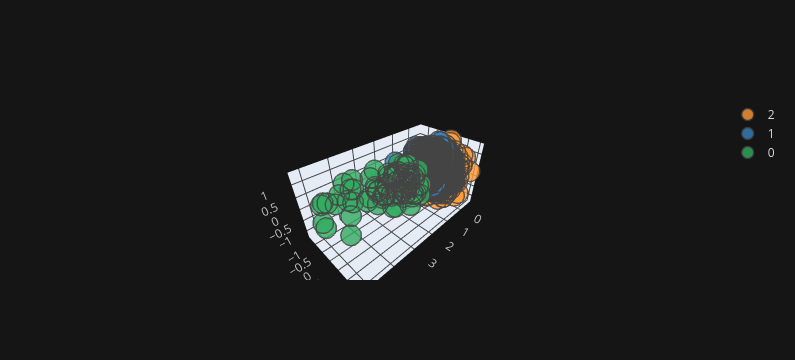

In [163]:
Xp.join(df_final[["title"]]).iplot(kind="scatter3d", x="p1", y="p2", z="p3", mode="markers", categories="cl", text="title", theme="solar")

In [164]:
df_final.groupby("cl").mean().style.background_gradient(cmap='Blues')

In [165]:
df_final["cl"].value_counts(True)

1    0.483838
2    0.472727
0    0.043434
Name: cl, dtype: float64

0


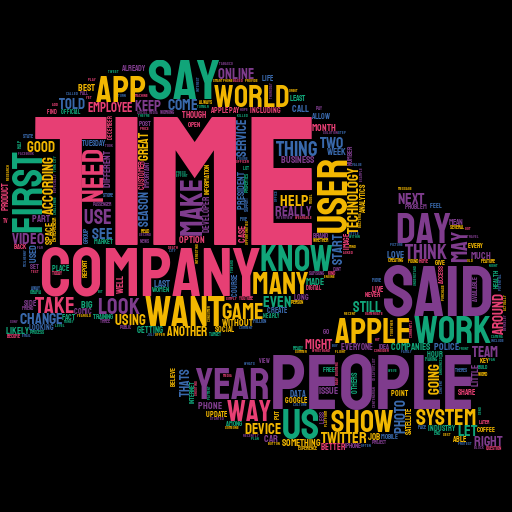

1


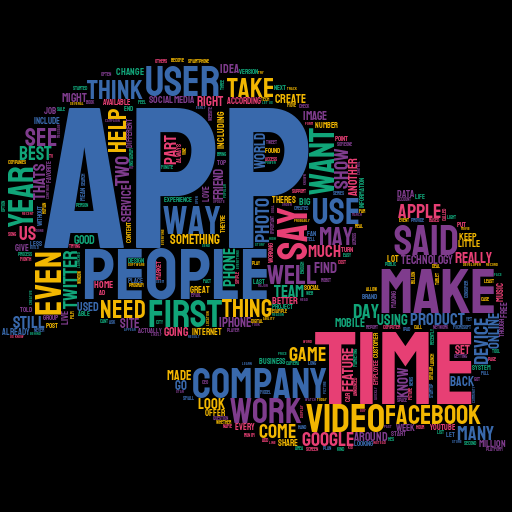

2


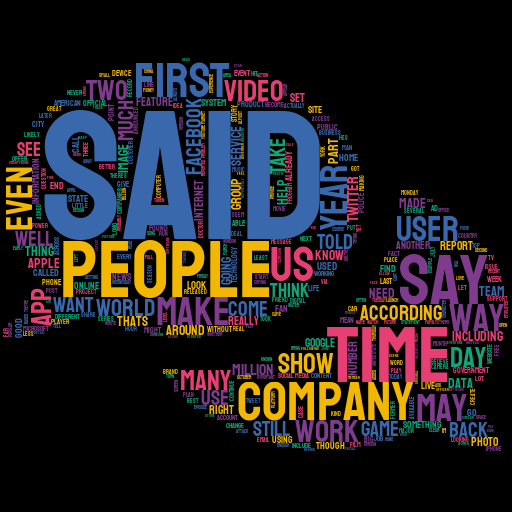

In [166]:
for cl in sorted(df_final["cl"].unique()):
    print(cl)
    display(get_wordcloud(" ".join(df_final.loc[df_final["cl"] == cl, "text_cleaned"])))

### Preservación de objetos

In [167]:
# Modelo supervisado
model.save("model.h5")
pd.to_pickle(sc, "sc_y.pickle")
pd.to_pickle(pipe, "pipe.pickle")
pd.to_pickle(ls_features, "features.pickle")
pd.to_pickle(tokenizer_title, "tokenizer_title.pickle")
pd.to_pickle(tokenizer_content, "tokenizer_content.pickle")
pd.to_pickle((title_max_words, title_max_sequence_length), "title_params.pickle")
pd.to_pickle((content_max_words, content_max_sequence_length), "content_params.pickle")
# Modelo no supervisado
pd.to_pickle(sc_x, "sc.pickle")
pd.to_pickle(cluster, "cluster.pickle")
model_transformer.save("model_transformer.h5")

In [168]:
shares.loc[~shares["url"].isin(df_final["url"]), "url"]

0        http://mashable.com/2013/01/07/amazon-instant-...
1        http://mashable.com/2013/01/07/ap-samsung-spon...
2        http://mashable.com/2013/01/07/apple-40-billio...
3        http://mashable.com/2013/01/07/astronaut-notre...
4         http://mashable.com/2013/01/07/att-u-verse-apps/
                               ...                        
39639    http://mashable.com/2014/12/27/samsung-app-aut...
39640    http://mashable.com/2014/12/27/seth-rogen-jame...
39641    http://mashable.com/2014/12/27/son-pays-off-mo...
39642       http://mashable.com/2014/12/27/ukraine-blasts/
39643    http://mashable.com/2014/12/27/youtube-channel...
Name: url, Length: 37664, dtype: object

In [169]:
shares.loc[0, "url"]

'http://mashable.com/2013/01/07/amazon-instant-video-browser/'